In [2]:
from feature_engeeniring import * 
from functions import *
from pipeline_gatehering import GatheringData

from sklearn.pipeline import Pipeline
import pandas as pd
import matplotlib.pyplot as plt
import warnings
plt.rcParams['figure.figsize'] = [20,8]
warnings.filterwarnings('ignore')

import pickle

import mlflow
import logging

# logging.basicConfig(level=logging.WARN)
# logger = logging.getLogger(__name__)

In [24]:
import json

def save_artifacts(data, file_name, directory='artifacts', dtype='json'):
#     print(file_name)
    path = f"{directory}/{file_name}.{dtype}"
    with open(f"{directory}/{file_name}.{dtype}", 'w', encoding='utf-8') as f:
        json.dump(data, f)


        
    mlflow.log_artifact(path, file_name) 
    
def save_model_as_artifact(model, file_name, directory='artifacts'):
    
    path = f"{directory}/model_{file_name}.pkl"
    model.save(path)
#     pickle.dump(model, open(path, 'wb+'))
    
    mlflow.log_artifact(path, file_name) 

def save_metrics_from_df(data, name=''):
    columns = data.columns.to_list()
    column_name = columns[1]

    for column_name in columns[1:]:
        column = data[column_name].values
        mlflow.log_metric(f'{column_name}_{name}_train', column[0])
        mlflow.log_metric(f'{column_name}_{name}_test', column[1])

def take_note_model(model, 
                    X_train, 
                    X_test, 
                    y_train, 
                    y_test, 
                    experiment_id, 
                    lambs=None,
                    com=None,
                    run_name=None,
                    log_lags=False,
                    log_com=False,
                    log_window=False,
                    log_columns_Lags=False,
                    log_columns_RollingMeanAverage=False,
                    log_columns_RollingMeanExponential=False,
                    log_columns_RollingStdAverage=False,
                    log_columns_RollingStdExponential=False,
                    log_lmbds=False,
                    log_feature_import_html=False,
                    log_model=True,
                    log_plot_pred_real=False,
                    log_plot_pred_trans=False
                   ):
    if lmbds is not None:
        lmbd = lmbds['Close']

    with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):

#         pipeline_0 = automl.get_pipeline(number_pipeline[i])
        
        model.fit(X_train, y_train)
        
        # geting prediction and residuals
        prediction_train, prediction_test, error_train, error_test = get_prediction_error_from_pipeline_autoMl(model, X_train, X_test, y_train, y_test)

        # inversed `Close` to real values
        if lmbds is not None:
            inv_y, inv_pred_train, inv_pred_test, inv_error_train, inv_error_train =  inv_boxcox_prediction_and_realvalues(y, prediction_train, prediction_test, lmbd)

        # fill na using `linear`interpolation
        y_interpolated = df_resulting['Close'].interpolate('linear')[pd.concat([inv_pred_train, inv_pred_test], axis=0).index]

        if log_lags:
            mlflow.log_param('count of lags', lags)
            
        if log_com:    
            mlflow.log_param('com', com)
            
        if log_window:
            mlflow.log_param('window', window)
            
        if log_columns_Lags:
            save_artifacts(data=columns_Lags, file_name='columns_Lags')
            
        if log_columns_RollingMeanAverage:    
            save_artifacts(data=columns_RollingMeanAverage, file_name='columns_RollingMeanAverage')
        
        if log_columns_RollingMeanExponential:
            save_artifacts(data=columns_RollingMeanExponential, file_name='columns_RollingMeanExponential')
           
        if log_columns_RollingStdAverage:
            save_artifacts(data=columns_RollingStdAverage, file_name='columns_RollingStdAverage')
        
        if log_columns_RollingStdExponential:
            save_artifacts(data=columns_RollingStdExponential, file_name='columns_RollingStdExponential')
        
        if log_lmbds:
            save_artifacts(data=lmbds, file_name='lambds')

        #  Write first artifact `features importances`
        if log_feature_import_html:
            data = dict([(feature, value) for feature , value in zip(model.feature_importance['feature'], model.feature_importance['importance'])]) 
            save_artifacts(data=data, file_name='feature_importances')

            # save html from feature importances 
            file_name = 'feature_importance_plot'
            path = f'artifacts/{file_name}.html'
            model.graph_feature_importance().write_html(path)
            mlflow.log_artifact(path, file_name)
        
        if log_plot_pred_trans:
            path, file_name = show_pred(y_train=prediction_train,
                                         y_test=prediction_test,
                                         y=pd.concat([y_train, y_test], axis=0),
                                         title=run_name,
                                         directory='artifacts',
                                         file_name='predition_real')
            
            mlflow.log_artifact(path, file_name)
            
        if log_plot_pred_real and lambs is not None:
            path, file_name = show_pred(y_train=inv_pred_train,
                                        y_test=inv_pred_test,
                                        y=y_interpolated,
                                        title=run_name,
                                        directory='artifacts',
                                        file_name='predition_trans')

            mlflow.log_artifact(path, file_name)
            
        # statistics for error
        error_describing = get_describin_from_residuals(error_train, error_test)

        # statistics for error_inverses 
        if lmbds is not None:
            error_train_inverses, error_test_inverses = get_error(y_interpolated, inv_pred_train, inv_pred_test)
            error_describing_inverses = get_describin_from_residuals(error_train=error_train_inverses, error_test=error_test_inverses)

            # Statisctics residual concatenated
            error_describing.columns = [x + '_transformed' for x in error_describing.columns]
            error_describing_inverses.columns = [x + '_real' for x in error_describing_inverses.columns]

            file_name = 'error_desciptions_concated'
            error_desciptions_concated = pd.concat([error_describing, error_describing_inverses], axis=1)
            data = error_desciptions_concated.to_dict()
            save_artifacts(data, file_name)  
        
        else:
            file_name = 'error_desciptions'
            data = error_describing.to_dict()
            save_artifacts(data, file_name) 

        # save the model 
        if log_model:
            save_model_as_artifact(model, file_name=run_name)

        # add metrics from inverted values
    #     df_metrics_inverted = define_metrics(inv_y, inv_pred_train, inv_pred_test, name='Linar')
    #     save_metrics_from_df(df_metrics_inverted, name='inv')

        # add metrics from real values
        if lmbds is not None:
            df_metrics_real = define_metrics(y_interpolated, inv_pred_train, inv_pred_test, name='Linar')
            save_metrics_from_df(df_metrics_real)

        # added graficts for residuals
        directory = 'artifacts'
        file_name = 'transformed'
        file_names, pathes = show_train_test_residual(error_train, error_test, directory=directory, file_name=file_name)

        for path, file_name in zip(pathes,file_names):
            mlflow.log_artifact(path, file_name)

        # added graficts for residuals'
        if lmbds is not None:
            directory = 'artifacts'
            file_name = 'real'
            file_names, pathes = show_train_test_residual(error_train_inverses, error_test_inverses, directory=directory, file_name=file_name)

            for path, file_name in zip(pathes,file_names):
                mlflow.log_artifact(path, file_name)

In [3]:
experiment_name = 'Transform only TARGET'
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
experiment_id

'5'

In [3]:
%%time
kw_list = [
          'bitcoin', 
          'bitcoin price',
          'bitcoin usd',
          'bitcoin kurs',
            'Bitcoin.com',
            'Bitcoin Gold',
           'BTC-USD',     
            'Bitcoin Cash',
           'binance',
    
    
            'cryptocurrency',
            'cryptocurrency bitcoin',
           'news cryptocurrency',
           'crypto',
           'buy bitcoin',
           'bitcoin stock',
           'best cryptocurrency',
           'cryptocurrency market',
           'buy cryptocurrency',
           'what is cryptocurrency',
           'cryptocurrency exchange',
          ]

kw_list_yahoo = ['BTC-USD']


get_data = GatheringData()
df_trends = get_data.get_from_google_trends(kw_list=kw_list, resample='D')
df_yahoo = get_data.get_from_yahoo(kw_list=kw_list_yahoo)
df_resulting = get_data.get_resulting_from_sources()
# df_resulting = get_data.drop_columns_result_data(columns=)

  0%|          | 0/20 [00:00<?, ?it/s]

gathering pytrends


  0%|          | 0/1 [00:00<?, ?it/s]

gathering yahoo


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

CPU times: user 3.12 s, sys: 42 ms, total: 3.17 s
Wall time: 12.3 s


In [4]:
# df_resulting.head()
columns_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
df_resulting = get_data.drop_columns_result_data(columns=columns_drop)
df_resulting.head()

,Close,bitcoin,bitcoin price,bitcoin usd,bitcoin kurs,Bitcoin.com,Bitcoin Gold,BTC-USD,Bitcoin Cash,binance,...,cryptocurrency bitcoin,news cryptocurrency,crypto,buy bitcoin,bitcoin stock,best cryptocurrency,cryptocurrency market,buy cryptocurrency,what is cryptocurrency,cryptocurrency exchange
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-10,421.563995,2.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-04-11,422.483002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-12,425.190002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-13,423.734009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-14,424.282013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_resulting.to_csv('../../data_dm/eduard/df_resulting.csv')

# Showing dataset after gathering data from our sources

In [4]:
df_resulting = pd.read_csv('../../data_dm/eduard/df_resulting.csv', header=0, index_col=0, parse_dates=True, dtype='float32')
df_resulting.head()

,Close,bitcoin,bitcoin price,bitcoin usd,bitcoin kurs,Bitcoin.com,Bitcoin Gold,BTC-USD,Bitcoin Cash,binance,...,cryptocurrency bitcoin,news cryptocurrency,crypto,buy bitcoin,bitcoin stock,best cryptocurrency,cryptocurrency market,buy cryptocurrency,what is cryptocurrency,cryptocurrency exchange
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-10,421.563995,2.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,...,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-04-11,422.483002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-12,425.190002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-13,423.734009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-14,424.282013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_resulting.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1834 entries, 2016-04-10 to 2021-04-17
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Close                    1830 non-null   float32
 1   bitcoin                  261 non-null    float32
 2   bitcoin price            261 non-null    float32
 3   bitcoin usd              261 non-null    float32
 4   bitcoin kurs             261 non-null    float32
 5   Bitcoin.com              261 non-null    float32
 6   Bitcoin Gold             261 non-null    float32
 7   BTC-USD                  261 non-null    float32
 8   Bitcoin Cash             261 non-null    float32
 9   binance                  261 non-null    float32
 10  cryptocurrency           261 non-null    float32
 11  cryptocurrency bitcoin   261 non-null    float32
 12  news cryptocurrency      261 non-null    float32
 13  crypto                   261 non-null    float32
 14  buy bi

# Preparing data and show dataset after preparation

In [17]:
columns_results = df_resulting.columns.to_list()

columns_TranformTimeSeries = ['Close']
columns_Lags = columns_results
columns_RollingMeanAverage = columns_results
columns_RollingStdAverage = columns_results
columns_RollingMeanExponential = columns_results
columns_RollingStdExponential = columns_results
columns_DinamicsForTimeSeries = ['Close']
lags = 7
com = 0.7
window = 7

pipeline = Pipeline([('Interpolation', Interpolation()),
    
#                     ('TranformTimeSeries', TranformTimeSeries(box_cox=columns_TranformTimeSeries)),
                     
                    ('Lags',Lags(lags=lags, 
                                 columns=columns_Lags)),
                      
                    ('RollingMeanAverage', RollingMeanAverage(window=window,
                                                              columns=columns_RollingMeanAverage)),
                      
                    ('RollingStdAverage', RollingStdAverage(window=window, 
                                                            columns=columns_RollingStdAverage)),
                      
                    ('RollingMeanExponential', RollingMeanExponential(window=window, 
                                                                      com=com,
                                                                      columns=columns_RollingMeanExponential)),
                      
                    ('RollingStdExponential', RollingStdExponential(window=window, 
                                                                    com=com,
                                                                    columns=columns_RollingStdExponential)),
                    ('DayWeekYear', DayWeekYear()),
                    ('DinamicsForTimeSeries', DinamicsForTimeSeries(columns=columns_DinamicsForTimeSeries))])

pipeline.fit(df_resulting)
X_transformed = pipeline.transform(df_resulting)
X_transformed.head()

,Close,bitcoin,bitcoin price,bitcoin usd,bitcoin kurs,Bitcoin.com,Bitcoin Gold,BTC-USD,Bitcoin Cash,binance,...,best cryptocurrency_ewn_std_7,cryptocurrency market_ewn_std_7,buy cryptocurrency_ewn_std_7,what is cryptocurrency_ewn_std_7,cryptocurrency exchange_ewn_std_7,weak,month,year,weekDay,Close_dinamic
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-01,451.875000,3.000000,1.0,2.0,1.0,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.134816,0.134816,17,5,2016,6,1.007934
2016-05-02,444.669006,2.857143,1.0,2.0,1.0,0.428571,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.095330,0.095330,18,5,2016,0,0.984053
2016-05-03,450.303986,2.714286,1.0,2.0,1.0,0.857143,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.126803,0.126803,18,5,2016,1,1.012672
2016-05-04,446.721985,2.571429,1.0,2.0,1.0,1.285714,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.159297,0.159297,18,5,2016,2,0.992045
2016-05-05,447.976013,2.428571,1.0,2.0,1.0,1.714286,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.179855,0.179856,18,5,2016,3,1.002807


In [18]:
X_transformed = X_transformed.astype('float32')
print(X_transformed.info())
X_transformed.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1813 entries, 2016-05-01 to 2021-04-17
Columns: 677 entries, Close to Close_dinamic
dtypes: float32(677)
memory usage: 4.7 MB
None


,Close,bitcoin,bitcoin price,bitcoin usd,bitcoin kurs,Bitcoin.com,Bitcoin Gold,BTC-USD,Bitcoin Cash,binance,...,best cryptocurrency_ewn_std_7,cryptocurrency market_ewn_std_7,buy cryptocurrency_ewn_std_7,what is cryptocurrency_ewn_std_7,cryptocurrency exchange_ewn_std_7,weak,month,year,weekDay,Close_dinamic
Date,,,,,,,,,,,,,,,,,,,,,
2016-05-01,451.875000,3.000000,1.0,2.0,1.0,0.000000,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.134816,0.134816,17.0,5.0,2016.0,6.0,1.007934
2016-05-02,444.669006,2.857143,1.0,2.0,1.0,0.428571,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.095330,0.095330,18.0,5.0,2016.0,0.0,0.984053
2016-05-03,450.303986,2.714286,1.0,2.0,1.0,0.857143,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.126803,0.126803,18.0,5.0,2016.0,1.0,1.012672
2016-05-04,446.721985,2.571429,1.0,2.0,1.0,1.285714,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.159297,0.159297,18.0,5.0,2016.0,2.0,0.992045
2016-05-05,447.976013,2.428571,1.0,2.0,1.0,1.714286,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.179855,0.179856,18.0,5.0,2016.0,3.0,1.002807


## Spliting on train and test set

In [19]:
X = X_transformed.drop('Close', axis=1).copy()
y = X_transformed['Close'].copy()

percentage = 0.1
train_len = int(X_transformed.shape[0] * 0.1)

X_train , X_test, y_train, y_test = X.iloc[:-train_len,:], X.iloc[-train_len:,:], y[:-train_len], y[-train_len:]

print(f'X_train:\t{X_train.shape}')
print(f'X_test:\t{X_test.shape}')
print(f'y_train:\t{y_train.shape}')
print(f'y_test:\t{y_test.shape}')

X_train:	(1632, 676)
X_test:	(181, 676)
y_train:	(1632,)
y_test:	(181,)


# Finding the best models

In [9]:
import evalml
from evalml import AutoMLSearch

In [9]:
# automl = pickle.load(open('models/automl_bitcoin.pkl', 'rb'))

In [20]:
# lmbds = pipeline['TranformTimeSeries'].lmbds
# lmbd = lmbds['Close']

run_name='AutoMl pipelines'

log_columns_Lags = True
log_columns_RollingMeanAverage = True
log_columns_RollingMeanExponential = True
log_columns_RollingStdAverage = True
log_columns_RollingStdExponential = True
log_lmbds = False


with mlflow.start_run(experiment_id=experiment_id, run_name=run_name):

    automl = AutoMLSearch(X_train=X_train,
                         y_train=y_train,
                          problem_type='regression',
                          objective='r2',
                          additional_objectives=['mae', 'mse','expvariance']
                         )
    automl.search()
    
    
    mlflow.log_param('count of lags', lags)
    mlflow.log_param('com', com)
    mlflow.log_param('window', window)

    if log_columns_Lags:
        save_artifacts(data=columns_Lags, file_name='columns_Lags')

    if log_columns_RollingMeanAverage:    
        save_artifacts(data=columns_RollingMeanAverage, file_name='columns_RollingMeanAverage')

    if log_columns_RollingMeanExponential:
        save_artifacts(data=columns_RollingMeanExponential, file_name='columns_RollingMeanExponential')

    if log_columns_RollingStdAverage:
        save_artifacts(data=columns_RollingStdAverage, file_name='columns_RollingStdAverage')

    if log_columns_RollingStdExponential:
        save_artifacts(data=columns_RollingStdExponential, file_name='columns_RollingStdExponential')

    if log_lmbds:
        save_artifacts(data=lmbds, file_name='lambds')
    
    save_model_as_artifact(automl, file_name='AutoMl')

Using default limit of max_batches=1.

Generating pipelines to search over...
*****************************
* Beginning pipeline search *
*****************************

Optimizing for R2. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 1 batches for a total of 9 pipelines. 
Allowed model families: catboost, xgboost, random_forest, extra_trees, lightgbm, linear_model, decision_tree



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Batch 1: (1/9) Mean Baseline Regression Pipeline        Elapsed:00:00
	Starting cross validation
	Finished cross validation - mean R2: -0.003
High coefficient of variation (cv >= 0.2) within cross validation scores. Mean Baseline Regression Pipeline may not perform as estimated on unseen data.
Batch 1: (2/9) Decision Tree Regressor w/ Imputer       Elapsed:00:01
	Starting cross validation
	Finished cross validation - mean R2: 0.996
Batch 1: (3/9) Extra Trees Regressor w/ Imputer         Elapsed:00:11
	Starting cross validation
	Finished cross validation - mean R2: 0.998
Batch 1: (4/9) XGBoost Regressor w/ Imputer             Elapsed:00:22
	Starting cross validation
	Finished cross validation - mean R2: 0.998
Batch 1: (5/9) CatBoost Regressor w/ Imputer            Elapsed:00:35
	Starting cross validation
	Finished cross validation - mean R2: 0.408
Batch 1: (6/9) Random Forest Regressor w/ Imputer       Elapsed:00:45
	Starting cross validation
	Finished cross validation - mean R2: 0.997


In [21]:
automl.rankings

,id,pipeline_name,score,validation_score,percent_better_than_baseline,high_variance_cv,parameters
0,7,Linear Regressor w/ Imputer + Standard Scaler,1.000000,1.000000,34928.474640,False,{'Imputer': {'categorical_impute_strategy': 'm...
1,3,XGBoost Regressor w/ Imputer,0.998152,0.999515,34864.099453,False,{'Imputer': {'categorical_impute_strategy': 'm...
2,2,Extra Trees Regressor w/ Imputer,0.997654,0.998649,34846.759005,False,{'Imputer': {'categorical_impute_strategy': 'm...
3,5,Random Forest Regressor w/ Imputer,0.997474,0.998648,34840.512019,False,{'Imputer': {'categorical_impute_strategy': 'm...
4,1,Decision Tree Regressor w/ Imputer,0.996221,0.997387,34796.857434,False,{'Imputer': {'categorical_impute_strategy': 'm...
5,8,Elastic Net Regressor w/ Imputer + Standard Sc...,0.995512,0.996641,34772.147931,False,{'Imputer': {'categorical_impute_strategy': 'm...
6,6,LightGBM Regressor w/ Imputer,0.980866,0.984077,34262.081212,False,{'Imputer': {'categorical_impute_strategy': 'm...
7,4,CatBoost Regressor w/ Imputer,0.408317,0.415319,14321.042050,False,{'Imputer': {'categorical_impute_strategy': 'm...
8,0,Mean Baseline Regression Pipeline,-0.002871,-0.000010,0.000000,True,{'Baseline Regressor': {'strategy': 'mean'}}


# Show the best model and other charachteristics

In [56]:
automl.rankings['id'][:5].values

array([7, 3, 2, 5, 1])

In [11]:
n = 5
number_pipeline = automl.rankings['id'][:n].values

# loading pipeline with model
# path = 'models/linarRegression_pipeline_bitcoin.pkl'
# pipeline_0 = pickle.load(open(path, 'rb'))

In [18]:
i = 0
pipeline_0 = automl.get_pipeline(number_pipeline[i])

pipeline_0.fit(X_train, y_train)

GeneratedPipeline(parameters={'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'categorical_fill_value': None, 'numeric_fill_value': None}, 'Linear Regressor':{'fit_intercept': True, 'normalize': False, 'n_jobs': -1},})

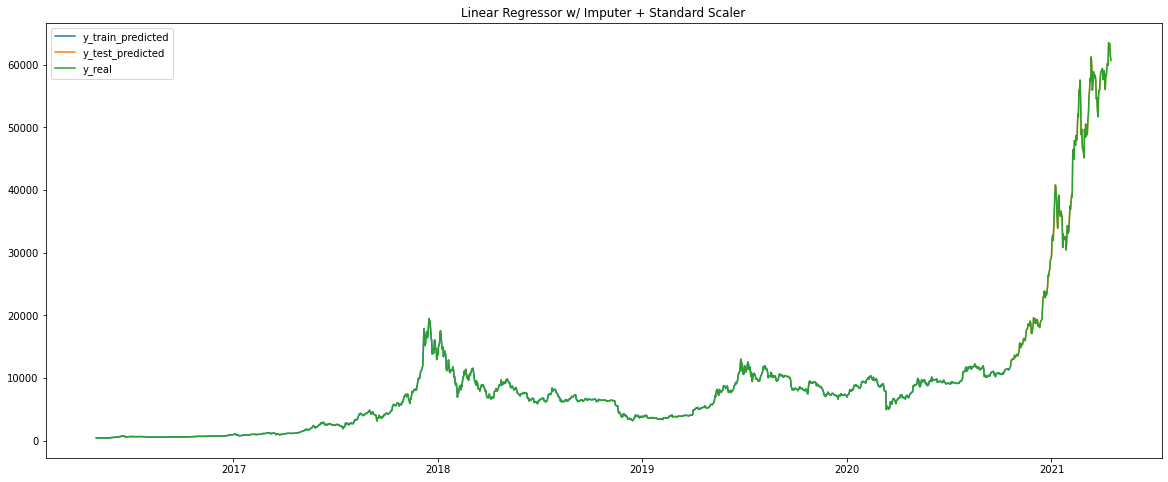

transformed
real


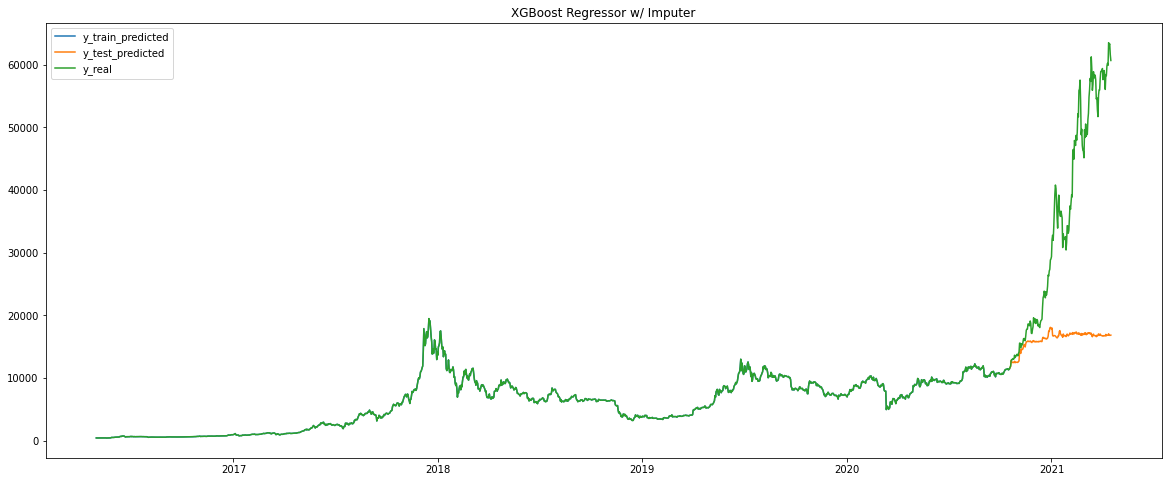

transformed
real


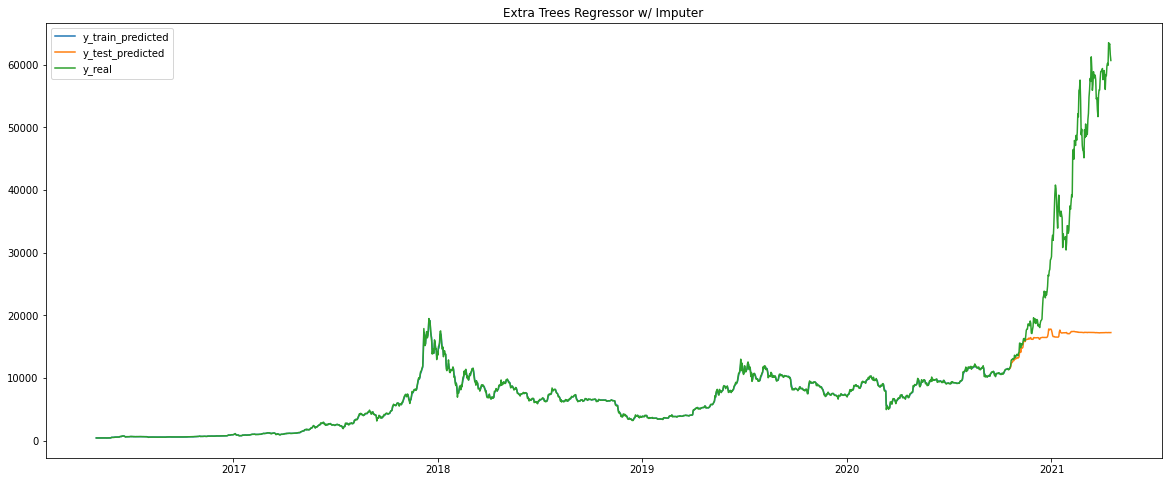

transformed
real


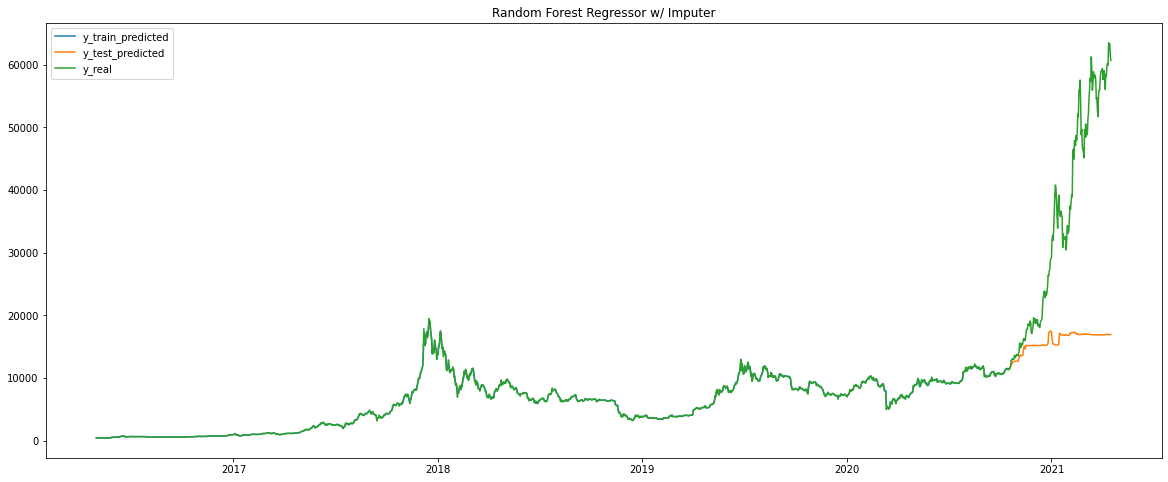

transformed
real


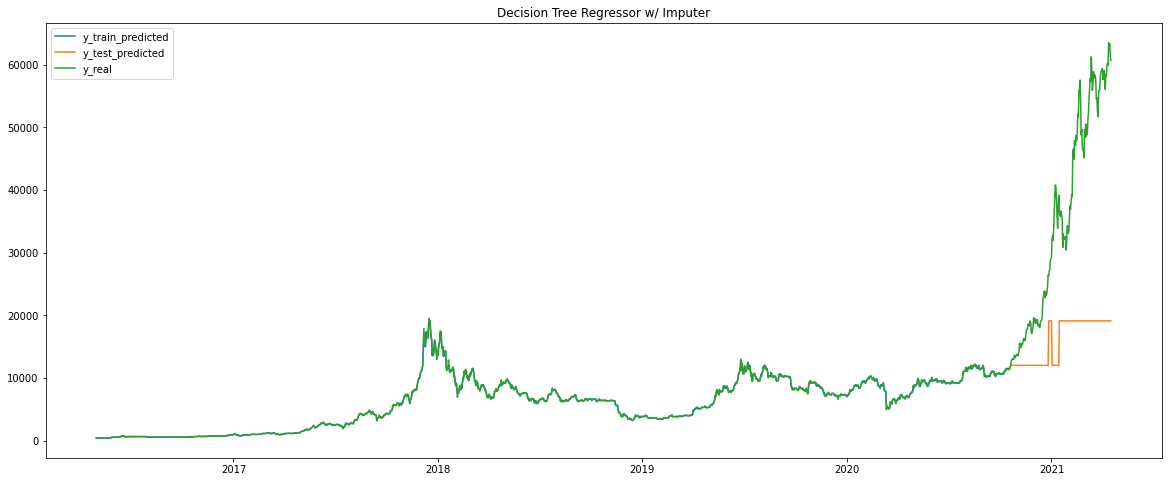

transformed
real
CPU times: user 1min 34s, sys: 24.2 s, total: 1min 58s
Wall time: 48.3 s


In [25]:
%%time

i = 0

n = 5
number_pipeline = automl.rankings['id'][:n].values
pipeline_names = automl.rankings['pipeline_name'][:n].values

for i, run_name in zip(number_pipeline, pipeline_names):

    pipeline_10 = automl.get_pipeline(i)

    take_note_model(pipeline_10, 
                    X_train, 
                    X_test, 
                    y_train, 
                    y_test, 
                    experiment_id=experiment_id,
                    lambs= None,#lmbds,
                    com=com,
                    run_name=run_name,

                    log_lags=True,
                    log_com=True,
                    log_window=True,
                    log_columns_Lags=False,
                    log_columns_RollingMeanAverage=False,
                    log_columns_RollingMeanExponential=False,
                    log_columns_RollingStdAverage=False,
                    log_columns_RollingStdExponential=False,
                    log_lmbds=False,
                    log_feature_import_html=True,
                    log_model=False,
                    log_plot_pred_real=True,
                    log_plot_pred_trans=True
                   )

## Deleting trend

In [147]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))
        
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=rolling_value).mean() 
    rolstd = pd.Series(timeseries).rolling(window=rolling_value).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

In [149]:
y

Date
2016-04-10      421.563995
2016-04-11      422.483002
2016-04-12      425.190002
2016-04-13      423.734009
2016-04-14      424.282013
                  ...     
2021-04-13    63503.457031
2021-04-14    63109.695312
2021-04-15    63314.011719
2021-04-16    61572.789062
2021-04-17    60664.132812
Name: Close, Length: 1834, dtype: float32

In [151]:
y_10lag

Date
2016-04-10            NaN
2016-04-11       0.919006
2016-04-12       2.707001
2016-04-13      -1.455994
2016-04-14       0.548004
                 ...     
2021-04-13    3610.003906
2021-04-14    -393.761719
2021-04-15     204.316406
2021-04-16   -1741.222656
2021-04-17    -908.656250
Name: Close, Length: 1834, dtype: float32

In [154]:
import statsmodels.api as sm

def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

In [156]:
y

Date
2016-04-10      421.563995
2016-04-11      422.483002
2016-04-12      425.190002
2016-04-13      423.734009
2016-04-14      424.282013
                  ...     
2021-04-13    63503.457031
2021-04-14    63109.695312
2021-04-15    63314.011719
2021-04-16    61572.789062
2021-04-17    60664.132812
Name: Close, Length: 1834, dtype: float32

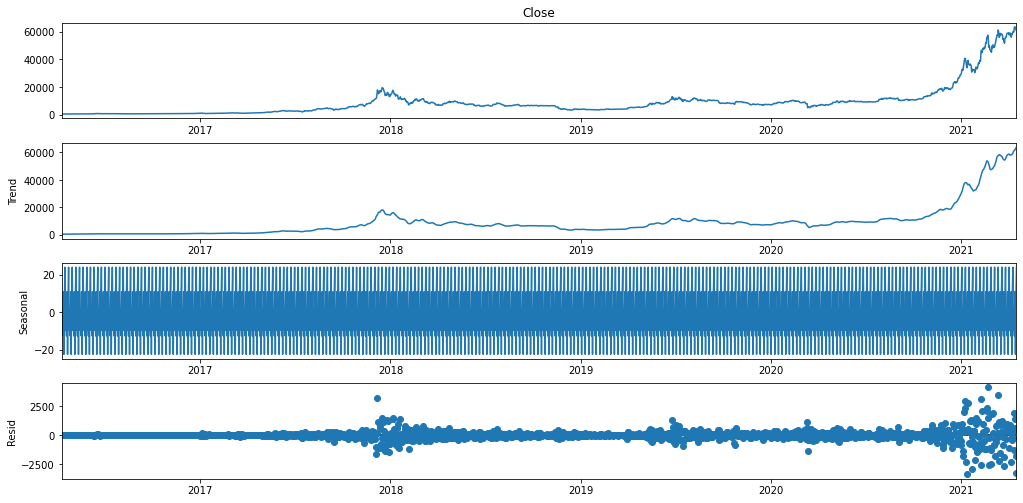

In [158]:
seasonal_decompose(y.interpolate('linear'))

In [167]:
# Differencing
diff_model = 1
y_10lag = y - y.shift(diff_model)
# y_10lag = pd.DataFrame({'Close':y_10lag}, index=y.index)

# test_stationarity(y_10lag.values,f'{diff_model} lag differenced data')
ADF_test(y_10lag,f'{diff_model} lag differenced data')

 > Is the 1 lag differenced data stationary ?
Test statistic = -7.822
P-value = 0.000
Critical values :
	1%: -3.4339881389288407 - The data is  stationary with 99% confidence
	5%: -2.863147035877915 - The data is  stationary with 95% confidence
	10%: -2.567625533641975 - The data is  stationary with 90% confidence


<AxesSubplot:xlabel='Date'>

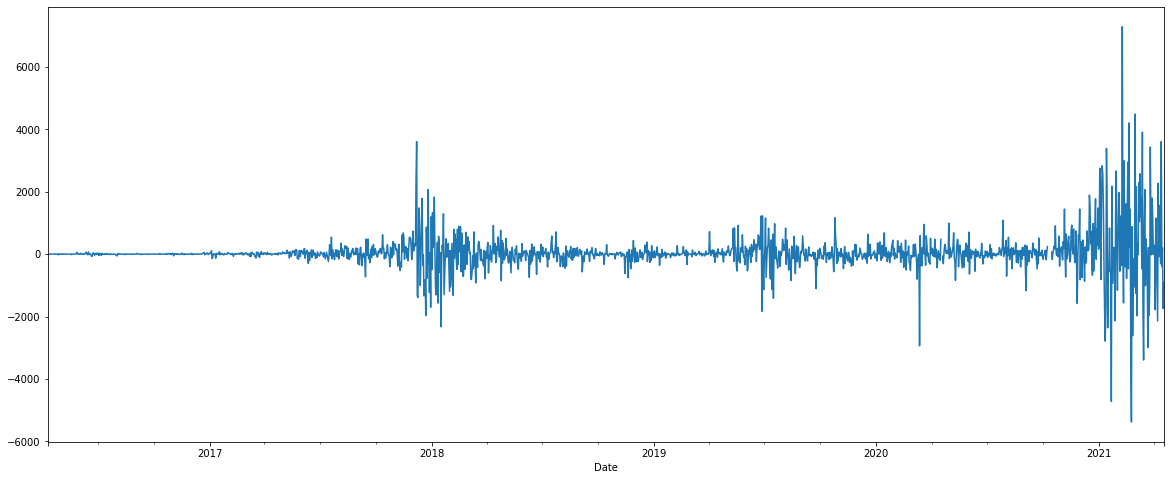

In [168]:
y_10lag.plot()